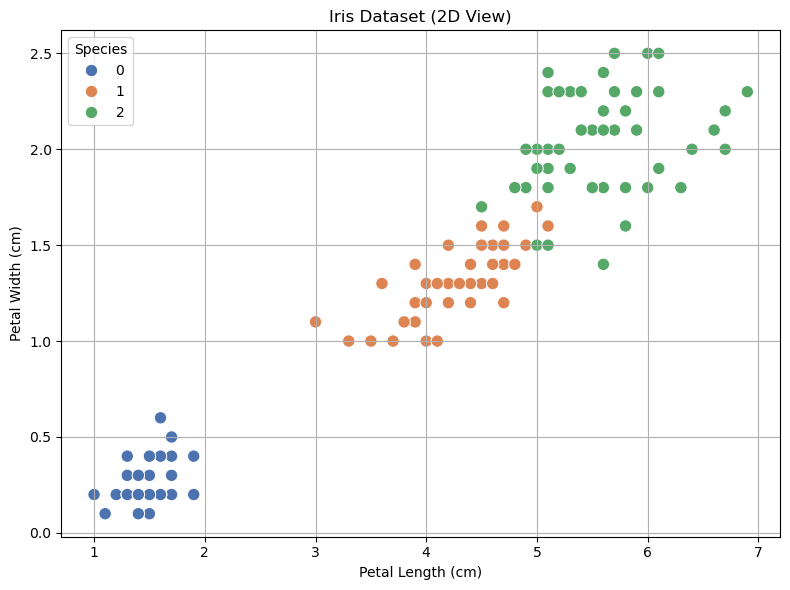

In [72]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['Species'] = iris.target

# Select only 2 features
df_2d = df[['petal length (cm)', 'petal width (cm)', 'Species']]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_2d,
    x='petal length (cm)',
    y='petal width (cm)',
    hue='Species',
    palette='deep',
    s=80
)
plt.title('Iris Dataset (2D View)')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Species')
plt.show()



X = df_2d[['petal length (cm)', 'petal width (cm)']].values

pr_mean = X.mean(axis=0)

pr_cov = np.cov(X, rowvar=False)

In [83]:
def neal_MCMC(X, alpha, num_iter):
    N, d = X.shape
    assert d == 2

    prior_mean = pr_mean
    prior_cov = pr_cov
    likelihood_cov = 0.5 * np.eye(2)  

    z = np.zeros(N, dtype=int)
    cluster_counts = {0: N}
    cluster_sums = {0: X.sum(axis=0)}
    theta = {0: np.random.multivariate_normal(prior_mean, prior_cov)}
    
    next_cluster_id = 1
    active_cluster_counts = []
    theta_history = {0: [theta[0].copy()]}

    inv_likelihood_cov = np.linalg.inv(likelihood_cov)
    inv_prior_cov = np.linalg.inv(prior_cov)

    for iteration in range(num_iter):
        for i in range(N):
            old_k = z[i]
            cluster_counts[old_k] -= 1
            cluster_sums[old_k] -= X[i]
            if cluster_counts[old_k] == 0:
                del cluster_counts[old_k]
                del cluster_sums[old_k]
                del theta[old_k]
                del theta_history[old_k]

            log_probs = []
            active_clusters = list(cluster_counts.keys())

            for k in active_clusters:
                mu_k = theta[k]
                diff = X[i] - mu_k
                log_likelihood = -0.5 * diff.T @ inv_likelihood_cov @ diff
                log_probs.append(np.log(cluster_counts[k]) + log_likelihood)

            # Marginal for new cluster
            marginal_cov = prior_cov + likelihood_cov
            inv_marginal_cov = np.linalg.inv(marginal_cov)
            diff = X[i] - prior_mean
            log_marginal = -0.5 * diff.T @ inv_marginal_cov @ diff
            log_probs.append(np.log(alpha) + log_marginal)

            log_probs = np.array(log_probs)
            log_probs -= np.max(log_probs)
            probs = np.exp(log_probs)
            probs /= probs.sum()

            new_cluster_idx = np.random.choice(len(probs), p=probs)

            if new_cluster_idx == len(active_clusters):
                k_new = next_cluster_id
                next_cluster_id += 1
                post_cov = np.linalg.inv(inv_likelihood_cov + inv_prior_cov)
                post_mean = post_cov @ (inv_likelihood_cov @ X[i] + inv_prior_cov @ prior_mean)
                theta[k_new] = np.random.multivariate_normal(post_mean, post_cov)
                cluster_counts[k_new] = 0
                cluster_sums[k_new] = np.zeros(2)
                theta_history[k_new] = [theta[k_new].copy()]
                z[i] = k_new
            else:
                z[i] = active_clusters[new_cluster_idx]

            cluster_counts[z[i]] += 1
            cluster_sums[z[i]] += X[i]

        for k in cluster_counts:
            n_k = cluster_counts[k]
            sum_x = cluster_sums[k]
            post_cov = np.linalg.inv(n_k * inv_likelihood_cov + inv_prior_cov)
            post_mean = post_cov @ (inv_likelihood_cov @ sum_x + inv_prior_cov @ prior_mean)
            theta[k] = np.random.multivariate_normal(post_mean, post_cov)
            theta_history[k].append(theta[k].copy())

        active_cluster_counts.append(len(cluster_counts))

        if (iteration + 1) % 100 == 0:
            print(f"[Iter {iteration+1}] Active Clusters: {len(cluster_counts)}")

    return z, theta, active_cluster_counts, theta_history



z_neal, theta_neal, active_cluster_counts ,theta_history_neal= neal_MCMC(X, alpha=0.6, num_iter=5000)






[Iter 100] Active Clusters: 6
[Iter 200] Active Clusters: 5
[Iter 300] Active Clusters: 8
[Iter 400] Active Clusters: 4
[Iter 500] Active Clusters: 4
[Iter 600] Active Clusters: 7
[Iter 700] Active Clusters: 9
[Iter 800] Active Clusters: 4
[Iter 900] Active Clusters: 12
[Iter 1000] Active Clusters: 6
[Iter 1100] Active Clusters: 8
[Iter 1200] Active Clusters: 10
[Iter 1300] Active Clusters: 7
[Iter 1400] Active Clusters: 7
[Iter 1500] Active Clusters: 9
[Iter 1600] Active Clusters: 7
[Iter 1700] Active Clusters: 6
[Iter 1800] Active Clusters: 8
[Iter 1900] Active Clusters: 7
[Iter 2000] Active Clusters: 6
[Iter 2100] Active Clusters: 7
[Iter 2200] Active Clusters: 7
[Iter 2300] Active Clusters: 7
[Iter 2400] Active Clusters: 7
[Iter 2500] Active Clusters: 6
[Iter 2600] Active Clusters: 5
[Iter 2700] Active Clusters: 8
[Iter 2800] Active Clusters: 13
[Iter 2900] Active Clusters: 8
[Iter 3000] Active Clusters: 9
[Iter 3100] Active Clusters: 7
[Iter 3200] Active Clusters: 8
[Iter 3300] Ac

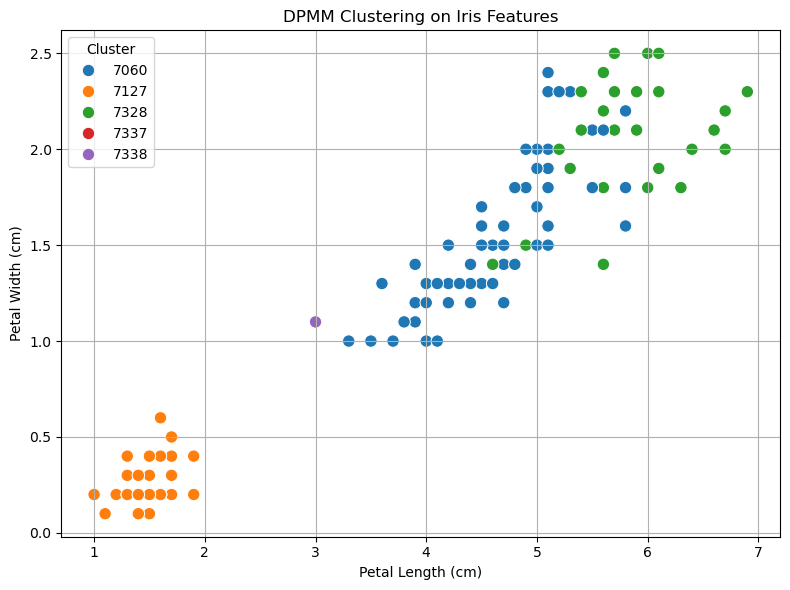

In [103]:

df_plot = pd.DataFrame(X, columns=['Petal Length', 'Petal Width'])
df_plot['Cluster'] = z_neal



import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x='Petal Length', y='Petal Width', hue='Cluster', palette='tab10', s=80)

plt.title("DPMM Clustering on Iris Features")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.grid(True)
plt.tight_layout()
plt.show()

                6M_Avg_Yield
Switzerland         0.292500
Japan               1.405000
Denmark             2.312500
Sweden              2.408900
Germany             2.536679
Korea               2.684000
Netherlands         2.754500
Finland             2.945960
Austria             2.981000
Portugal            3.110000
Belgium             3.140000
Canada              3.165000
Spain               3.219023
France              3.260000
Greece              3.405000
Italy               3.670500
Norway              3.952287
Czech Republic      4.120574
Australia           4.308500
United States       4.403333
Israel              4.405000
New Zealand         4.565000
United Kingdom      4.588300
Poland              5.355000
Hungary             6.970000
Mexico              9.335000
South Africa       11.227368


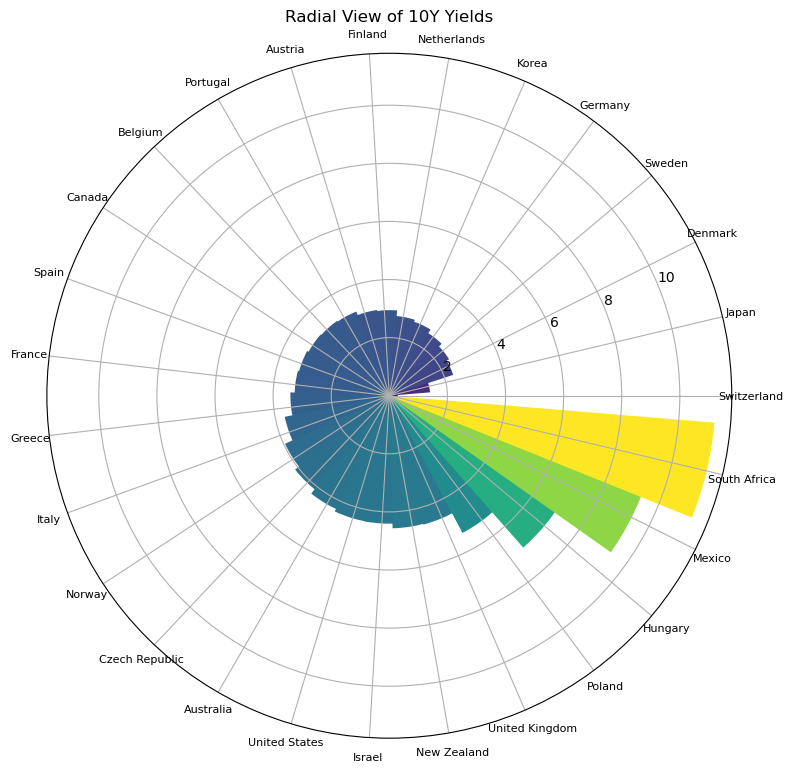

In [128]:


from fredapi import Fred
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt



fred = Fred(api_key="5067aaf936df9ab10e7879df555632c5")

codes = {
    # North America
    "United States": "DGS10",             # Constant-maturity 10-year yield
    "Canada"       : "IRLTLT01CAM156N",
    "Mexico"       : "IRLTLT01MXM156N",

    # Euro-Area Core & Periphery
    "Germany"      : "IRLTLT01DEM156N",
    "France"       : "IRLTLT01FRM156N",
    "Italy"        : "IRLTLT01ITM156N",
    "Spain"        : "IRLTLT01ESM156N",
    "Netherlands"  : "IRLTLT01NLM156N",
    "Belgium"      : "IRLTLT01BEM156N",
    "Austria"      : "IRLTLT01ATM156N",
    "Portugal"     : "IRLTLT01PTM156N",
    "Greece"       : "IRLTLT01GRM156N",
    "Ireland"      : "IRLTLT01IRM156N",
    "Finland"      : "IRLTLT01FIM156N",

    # Nordics
    "Sweden"       : "IRLTLT01SEM156N",
    "Norway"       : "IRLTLT01NOM156N",
    "Denmark"      : "IRLTLT01DKM156N",

    # UK & Switzerland
    "United Kingdom": "IRLTLT01GBM156N",
    "Switzerland"   : "IRLTLT01CHM156N",

    # Asia-Pacific
    "Japan"        : "IRLTLT01JPM156N",
    "Australia"    : "IRLTLT01AUM156N",
    "New Zealand"  : "IRLTLT01NZM156N",
    "Korea"        : "IRLTLT01KRM156N",

    # Central & Eastern Europe
    "Czech Republic": "IRLTLT01CZM156N",
    "Poland"        : "IRLTLT01PLM156N",
    "Hungary"       : "IRLTLT01HUM156N",

    # Middle East
    "Israel"        : "IRLTLT01ILM156N",

    # Africa
    "South Africa"  : "IRLTLT01ZAM156N"
}
end = datetime.today()
start = end - timedelta(days=30*2)

avg_yields = {}
for country, code in codes.items():
    try:
        series = fred.get_series(code, observation_start=start, observation_end=end)
        avg = series.mean()
        avg_yields[country] = avg
    except Exception:
        avg_yields[country] = None

df_avg = pd.DataFrame.from_dict(avg_yields, orient='index', columns=['6M_Avg_Yield']).dropna()


df_sorted = df_avg.sort_values("6M_Avg_Yield")
angles = np.linspace(0, 2 * np.pi, len(df_sorted), endpoint=False)
radii = df_sorted['6M_Avg_Yield']
labels = df_sorted.index

print(df_sorted)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, radii, width=0.3, color=plt.cm.viridis(radii / max(radii)))

ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=8, rotation=45)
ax.set_title("Radial View of 10Y Yields")
plt.tight_layout()
plt.show()


Y = df_sorted['6M_Avg_Yield'].values

In [152]:


def neal_MCMC_1D(X, alpha, num_iter):
    
    N = len(X)

    prior_mean = 4
    prior_var = 6          
    likelihood_var = 1    

    z = np.zeros(N, dtype=int)
    cluster_counts = {0: N}
    cluster_sums = {0: np.sum(X)}
    theta = {0: np.random.normal(prior_mean, np.sqrt(prior_var))}

    next_cluster_id = 1
    active_cluster_counts = []
    theta_history = {0: [theta[0]]}

    for iteration in range(num_iter):
        for i in range(N):
            old_k = z[i]
            cluster_counts[old_k] -= 1
            cluster_sums[old_k] -= X[i]

            if cluster_counts[old_k] == 0:
                del cluster_counts[old_k]
                del cluster_sums[old_k]
                del theta[old_k]
                del theta_history[old_k]

            active_clusters = list(cluster_counts.keys())
            log_probs = []

            for k in active_clusters:
                n_k = cluster_counts[k]
                mu_k = theta[k]
                ll = -0.5 * np.log(2 * np.pi * likelihood_var) - 0.5 * ((X[i] - mu_k) ** 2) / likelihood_var
                log_probs.append(np.log(n_k) + ll)

            # New cluster marginal likelihood
            post_var = prior_var + likelihood_var
            post_mean = prior_mean
            marginal_ll = -0.5 * np.log(2 * np.pi * post_var) - 0.5 * ((X[i] - post_mean) ** 2) / post_var
            log_probs.append(np.log(alpha) + marginal_ll)

            log_probs = np.array(log_probs)
            log_probs -= np.max(log_probs)
            probs = np.exp(log_probs)
            probs /= probs.sum()

            new_cluster_idx = np.random.choice(len(probs), p=probs)

            if new_cluster_idx == len(active_clusters):
                new_k = next_cluster_id
                next_cluster_id += 1

                posterior_var = 1.0 / (1 / prior_var + 1 / likelihood_var)
                posterior_mean = posterior_var * (X[i] / likelihood_var + prior_mean / prior_var)

                theta[new_k] = np.random.normal(posterior_mean, np.sqrt(posterior_var))
                cluster_counts[new_k] = 0
                cluster_sums[new_k] = 0.0
                theta_history[new_k] = [theta[new_k]]
                z[i] = new_k
            else:
                z[i] = active_clusters[new_cluster_idx]

            cluster_counts[z[i]] += 1
            cluster_sums[z[i]] += X[i]

        for k in cluster_counts:
            n_k = cluster_counts[k]
            sum_x = cluster_sums[k]

            posterior_var = 1.0 / (n_k / likelihood_var + 1 / prior_var)
            posterior_mean = posterior_var * (sum_x / likelihood_var + prior_mean / prior_var)

            theta[k] = np.random.normal(posterior_mean, np.sqrt(posterior_var))
            theta_history.setdefault(k, []).append(theta[k])

        active_cluster_counts.append(len(cluster_counts))

        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}/{num_iter}: {len(cluster_counts)} active clusters")

    return z, theta, active_cluster_counts, theta_history

z_neal, theta_neal, active_cluster_counts ,theta_history_neal= neal_MCMC_1D(Y, alpha=2, num_iter=5000)






Iteration 100/5000: 5 active clusters
Iteration 200/5000: 6 active clusters
Iteration 300/5000: 7 active clusters
Iteration 400/5000: 5 active clusters
Iteration 500/5000: 7 active clusters
Iteration 600/5000: 3 active clusters
Iteration 700/5000: 10 active clusters
Iteration 800/5000: 5 active clusters
Iteration 900/5000: 9 active clusters
Iteration 1000/5000: 8 active clusters
Iteration 1100/5000: 10 active clusters
Iteration 1200/5000: 7 active clusters
Iteration 1300/5000: 7 active clusters
Iteration 1400/5000: 4 active clusters
Iteration 1500/5000: 4 active clusters
Iteration 1600/5000: 6 active clusters
Iteration 1700/5000: 5 active clusters
Iteration 1800/5000: 4 active clusters
Iteration 1900/5000: 3 active clusters
Iteration 2000/5000: 5 active clusters
Iteration 2100/5000: 8 active clusters
Iteration 2200/5000: 7 active clusters
Iteration 2300/5000: 7 active clusters
Iteration 2400/5000: 5 active clusters
Iteration 2500/5000: 7 active clusters
Iteration 2600/5000: 7 active cl

In [153]:
# Ensure Y and z_neal are aligned with df_sorted (e.g., same row order)
df_clusters = df_sorted.copy()
df_clusters['Cluster'] = z_neal

# Reset index to bring country names into a column (if they were in the index)
df_clusters = df_clusters.reset_index().rename(columns={'index': 'Country'})


# Display
print(df_clusters[['Country', '6M_Avg_Yield', 'Cluster']])

           Country  6M_Avg_Yield  Cluster
0      Switzerland      0.292500    11713
1            Japan      1.405000    11611
2          Denmark      2.312500    11611
3           Sweden      2.408900    11611
4          Germany      2.536679    11714
5            Korea      2.684000    11611
6      Netherlands      2.754500    11611
7          Finland      2.945960    11611
8          Austria      2.981000    11611
9         Portugal      3.110000    11611
10         Belgium      3.140000    11611
11          Canada      3.165000    11611
12           Spain      3.219023    11611
13          France      3.260000    11611
14          Greece      3.405000    11611
15           Italy      3.670500    11611
16          Norway      3.952287    11611
17  Czech Republic      4.120574    11611
18       Australia      4.308500    11611
19   United States      4.403333    11710
20          Israel      4.405000    11611
21     New Zealand      4.565000    11611
22  United Kingdom      4.588300  

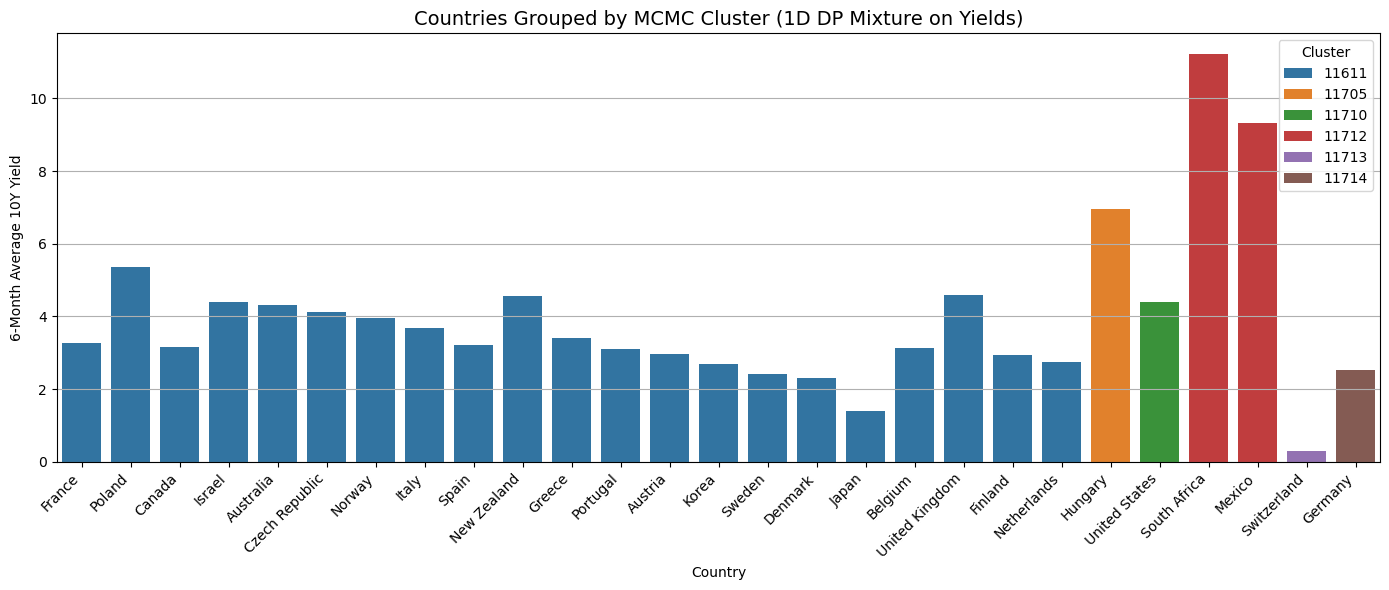

In [158]:

df_clusters = df_clusters.sort_values('Cluster')

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_clusters,
    x='Country', 
    y='6M_Avg_Yield', 
    hue='Cluster', 
    dodge=False, 
    palette='tab10'
)
plt.title('Countries Grouped by MCMC Cluster (1D DP Mixture on Yields)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('6-Month Average 10Y Yield')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()
